In [1]:
import os
from shutil import rmtree
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG=True
IPythonConsole.drawOptions.addAtomIndices=True
from tqdm import tqdm
import numpy as np
import pandas as pd

from serenityff.charge.tree.tree import tree
from serenityff.charge.tree.atom_features import AtomFeatures
from serenityff.charge.tree_develop.tree_constructor_parallel import Tree_constructor
from serenityff.charge.tree.tree_utils import get_rdkit_fragment_from_node_path

# Tree constructing

## Initializatrion

This notebook shows how to build a attention guided decision tree. To assign partial charges to the atoms of a molecule.
The building requires a sdf file with all the molecules and a csv file with all the attention data, generated with the `Extractor` class from `sereinityff`. Additionally, the user can provide certain options to the tree building process, like the ratio of building versus testing data. If the test data from the GNN training is still available, it can be used to test the tree, which is recommended for consistency.

In [2]:
data_file="../data/example_extraction.csv"
sdf_suply="../data/example.sdf" 
data_split = 0.2
out_folder = "./example_tree_out"
if os.path.exists(out_folder):
    rmtree(out_folder)
os.mkdir(out_folder)

All tools to build the tree are encapsulated in the `Tree_constructor` class. And we start by creating a instance of this class. Here we can also specify some additonal options, like how deep the tree should be build maximally (`num_layers=16`), if we want to sanitize the dataset and the verbosity level.

In [3]:
tree_constructor = Tree_constructor(df_path=data_file,
                sdf_suplier=sdf_suply,
                num_layers_to_build=16,
                data_split=data_split,
                verbose=True,
                sanitize=True,
                sanitize_charges=True)

2023-02-23 21:58:12.637963	Initializing Tree_constructor
2023-02-23 21:58:12.638308	Mols imported, starting df import
2023-02-23 21:58:12.667842	Sanitizing
2023-02-23 21:58:12.708089	Check charge sanity


100%|██████████| 20/20 [00:00<00:00, 879.11it/s]


Number of wrong charged mols: 0 of 20 mols
2023-02-23 21:58:12.745650	df imported, starting data spliting
2023-02-23 21:58:12.785678	Starting table filling


100%|██████████| 334/334 [00:00<00:00, 951.09it/s] 


Creating Adjacency matrices:


100%|██████████| 20/20 [00:00<00:00, 912.79it/s]

Number of train mols: 16
Number of test mols: 4


The tree_constructor will initalize, sanize the data and then split the data into build and testset. The test set will not be used and can at the end be retrived to test the tree and meta parameters.  

## Atom Features

The next step is to create the zeroth layer of the tree. The zeroth atom is always the atom we try to assign a partial charge. Therefore the zeroth layer of the tree corresponds to a list of all atom features present in the dataset. A atom feature contains all relevand information of an atom, and will be the identifaction of every node in the tree. The atom features are stored in a helper class `AtomFeature` and offer some useful methods to compare and use atom features.

In [4]:
atom_feture_key = 12
AtomFeatures.lookup_int(12)

'C 1 0 True 1'

A atom feature contains the following information:
 - Element type (e.g. C, N, O, ...)
 - Number of bonds (e.g. 1, 2, 3, ...)
 - Formal charge (e.g. -1, 0, 1, ...)
 - Hybridization (e.g. SP, SP2, SP3, ...)
 - Aromaticity (True or False)
 - Number of Hydrogens (e.g. 0, 1, 2, ...) (includeNeighbors=True)

These atom features are similar to the feature vector used in the GNN, but made more human readable. The atom features are stored in a dictionary, where the key is the atom index and the value is the atom feature.
During the tree building process we will build subgraphs for each atom in the dataset, guided by the attention values. The start of the subgraph is the zeroth atom itself. The subgraph will be build by adding the neighbors of the zeroth atom to the subgraph. The neighbors are selected by the attention values. Nodes of layers deeper than the zeroth layer will have the atom feature of the atom and the way it is connected to the current subgraph. For example `[12, 0, 1]` would mean that the atom with atom feature 12 is connected to atom 0 of the current subgraph with a single bond.

Atom features can be generated directly from rdkit molecules, and the class offers multiple tools to experiment with atom features.

Atom with idx:0 has AtomFeature: C 4 0 False 3


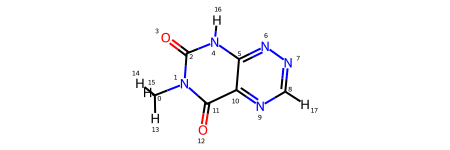

In [5]:
atom_idx_in_mol = 0
mol = Chem.SDMolSupplier(sdf_suply, removeHs=False)[0]
[mol.ClearProp(prop) for prop in mol.GetPropNames()]
atom_feture_key = AtomFeatures.atom_features_from_molecule(mol, 0)
print(f"Atom with idx:{atom_idx_in_mol} has AtomFeature: {AtomFeatures.lookup_int(atom_feture_key)}")
mol

In [6]:
print(f"In the current version of serenityff there are {AtomFeatures.get_number_of_features()} atom features")

In the current version of serenityff there are 122 atom features


If a molecule in the dataset would contain a atom with an atom feature that is not present in the dictionary, the tree could not be buid and needs to be added first. Therefore the tree can only assign partial charges to atoms with atom features in the set and will never extrapolate to new atom features.

## Building layers of the tree

The function `create_tree_level_0` will assign each atom in the dataset it's atom feature and create a branch conected to the root node of the tree for that atom feature with the data of all atoms belonging to that atom feature.

In [7]:
tree_constructor.create_tree_level_0()

Preparing Dataframe:
Creating Tree Level 0:


100%|██████████| 122/122 [00:00<00:00, 558.65it/s]

2023-02-23 21:58:22.078661	Layer 0 done


Now we can also build all the other layers of the tree, by always adding the neighbours with the highest attention to the tree for all atoms in the dataset. Since this takes a lot of time, we provide a implementation parallelized with multiprocessing. The number of processes can be specified with the `num_processes` parameter. And each branch, of the tree, corresponding to the different zeroth level atom features will be build in independent processes.

In [8]:
tree_constructor.build_tree(num_processes=4);

AF 8 done
AF 0 done
AF 24 done
AF 16 done
AF 9 done
AF 1 done
AF 25 done
AF 17 done
AF 10 done
AF 2 done
AF 18 done
AF 11 done
AF 3 done
AF 19 done
AF 12 done
AF 4 done
AF 20 done
AF 13 done
AF 5 done
AF 21 done
AF 14 done
AF 22 done
AF 15 done
AF 23 done
AF 40 done
AF 41 done
AF 42 done
AF 43 done
AF 44 done
AF 45 done
AF 46 done
AF 47 done
AF 48 done
AF 49 done
AF 50 done
AF 51 done
AF 52 done
AF 53 done
AF 54 done
AF 6 done
AF 7 done
AF 56 done
AF 32 done
AF 26 done
AF 57 done
AF 58 done
AF 59 done
AF 33 done
AF 60 done
AF 61 done
AF 27 done
AF 62 done
AF 34 done
AF 28 done
AF 35 done
AF 29 done
AF 63 done
AF 36 done
AF 30 done
AF 64 done
AF 31 done
AF 65 done
AF 72 done
AF 66 done
AF 73 done
AF 67 done
AF 74 done
AF 68 done
AF 75 done
AF 69 done
AF 55 done
AF 76 done
AF 70 done
AF 77 done
AF 71 done
AF 80 done
AF 78 done
AF 88 done
AF 81 done
AF 79 done
AF 89 done
AF 82 done
AF 96 done
AF 90 done
AF 83 done
AF 97 done
AF 91 done
AF 84 done
AF 98 done
AF 92 done
AF 99 done
AF 85 don

The tree should now be build in a raw form. The next step is to convert it to a form with averages and standard deviations, instead of the raw data in each node, making it very memory efficient.

In [9]:
tree_constructor.convert_tree_to_node(delDevelop=True)
tree_constructor.new_root.fix_nan_stdDeviation()

In [10]:
example_tree = tree()
example_tree.root = tree_constructor.new_root

we can now have a look at the tree and print all the branches wich are not empty in our simple example

In [11]:
for child in tree_constructor.new_root.children:
    if child.count != 0:
        print(child)

node 1 - -0.0935 - 1 - [[6, -1, -1]]
node 1 - 0.3128354838709677 - 31 - [[26, -1, -1]]
node 1 - -0.1376128205128205 - 39 - [[27, -1, -1]]
node 1 - 0.01603636363636364 - 11 - [[32, -1, -1]]
node 1 - -0.17137241379310345 - 29 - [[33, -1, -1]]
node 1 - -0.37962727272727276 - 11 - [[34, -1, -1]]
node 1 - 0.17150243902439025 - 164 - [[37, -1, -1]]
node 1 - -0.4999285714285714 - 7 - [[55, -1, -1]]
node 1 - -0.6428333333333334 - 3 - [[63, -1, -1]]
node 1 - -0.8688499999999999 - 2 - [[64, -1, -1]]
node 1 - 0.3 - 2 - [[65, -1, -1]]
node 1 - -0.644 - 1 - [[66, -1, -1]]
node 1 - -0.8984 - 3 - [[67, -1, -1]]
node 1 - 0.7318 - 1 - [[70, -1, -1]]
node 1 - -0.4154 - 1 - [[77, -1, -1]]
node 1 - -0.5555454545454545 - 11 - [[80, -1, -1]]
node 1 - -0.3793 - 1 - [[82, -1, -1]]
node 1 - -0.6645666666666666 - 3 - [[83, -1, -1]]
node 1 - -0.28486 - 5 - [[85, -1, -1]]
node 1 - -0.6039 - 5 - [[86, -1, -1]]
node 1 - -0.5892 - 1 - [[108, -1, -1]]
node 1 - 0.0235 - 1 - [[110, -1, -1]]
node 1 - -0.3137 - 1 - [[111

each node contains a atom feature and the data relevant for the partial charge.

## Test the example tree

Now the test set set asside at the beginning can be used to test the example tree we just build.

In [12]:
mol_idx_test = tree_constructor.test_df.mol_index.unique().tolist()

In [13]:
example_tree_charges = []
example_ref_charges = []
for mol_idx in mol_idx_test:
    mol = Chem.SDMolSupplier(sdf_suply, removeHs=False)[mol_idx]
    example_tree_charges.extend(example_tree.match_molecule_atoms(mol)[0])
    example_ref_charges.extend(tree_constructor.test_df[tree_constructor.test_df.mol_index == mol_idx].truth.values)    

In [14]:
df = pd.DataFrame({"tree":example_tree_charges, "ref":example_ref_charges})

In [15]:
df

,tree,ref
0,-0.351464,-0.2029
1,0.246924,-0.3875
2,0.736243,0.8998
3,-0.560567,-0.6535
4,-0.624176,-0.6427
...,...,...
92,0.097098,0.0944
93,0.097098,0.0820
94,0.097098,0.1117
95,0.105447,0.1020


Text(0.5, 1.0, 'Example tree charge correlation\n RMSE: 0.143 e')

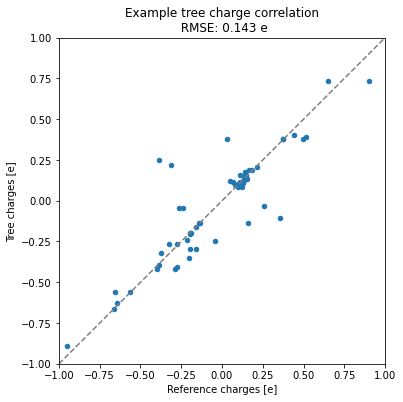

In [16]:
ax=df.plot.scatter(x="ref", y="tree", figsize=(6,6), xlim=(-1,1), ylim=(-1,1))
ax.set_aspect('equal')
ax.plot([-1,1],[-1,1], color="grey", linestyle="--")
ax.set_xlabel("Reference charges [e]")
ax.set_ylabel("Tree charges [e]")
ax.set_title(f"Example tree charge correlation\n RMSE: {np.sqrt(np.mean((df.tree-df.ref)**2)):.3f} e")

It can be seen, that even this very simple example tree can already assign partial charges with a decent accuracy. However, the small tree can not yet assign all molecules and with atoms with atom features not present in the training set the assigned charges will be NaN. In addition to the assigned charges we can also retrive the assignment path, the total attention values and the statistical errors.

## Test an example molecule with the example tree

In [17]:
example_mol = Chem.SDMolSupplier(sdf_suply, removeHs=False)[1]

In [33]:
partial_charge, path = example_tree.match_new_atom(1, example_mol)
path

[root,
 node 1 - 0.3128354838709677 - 31 - [[26, -1, -1]],
 node 1 - 0.7068 - 9 - [[80, 0, 2]],
 node 1 - 0.79985 - 4 - [[86, 0, 1]],
 node 1 - 0.77785 - 2 - [[26, 0, 1]],
 node 1 - 0.77785 - 2 - [[27, 3, 12]],
 node 1 - 0.7708 - 1 - [[55, 3, 12]],
 node 1 - 0.7708 - 1 - [[27, 5, 12]],
 node 1 - 0.7708 - 1 - [[27, 6, 12]],
 node 1 - 0.7708 - 1 - [[55, 4, 12]]]

In [34]:
charges_in_path = []
counts_in_path = []
attention_in_path = []
stdDev_in_path = []
for node in path:
    charges_in_path.append(node.result)
    counts_in_path.append(node.count)
    attention_in_path.append(node.attention)
    stdDev_in_path.append(node.stdDeviation)

We can also observe, how the assigned partial charge slowly converges to the final value along the node path trough the tree. 

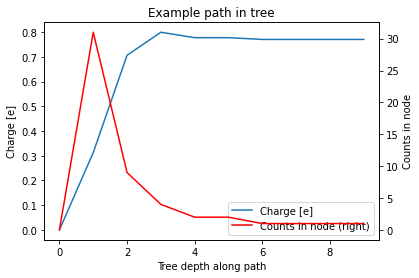

In [43]:
ax = pd.Series(charges_in_path).fillna(0).plot.line(label="Charge [e]")
ax2 = pd.Series(counts_in_path).plot.line(secondary_y=True, ax=ax, color="red", label="Counts in node")
ax.set_xlabel("Tree depth along path")
ax.set_ylabel("Charge [e]")
ax.set_title("Example path in tree")
ax.right_ax.set_ylabel("Counts in node")
ax.legend(handles=[ax.lines[0], ax2.lines[0]])

The above figure shows the number of counts decresing along the path through the tree, and going to 1, since our example dataset is so small, that we basically recover the full querry molecule. With a larger number of molecules in the dataset the averaging would be better, and we could use a certain attention value, collected along the path as stop marker for the matching to avoid overfitting.

Text(0.5, 1.0, 'Cumulative attention along path in the example tree')

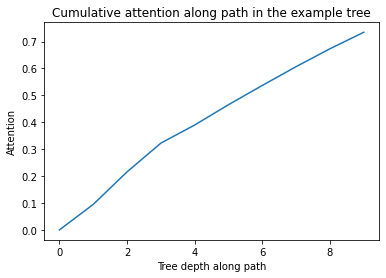

In [36]:
ax = pd.Series(attention_in_path).cumsum().fillna(0).plot.line(label="Attention")
ax.set_xlabel("Tree depth along path")
ax.set_ylabel("Attention")
ax.set_title("Cumulative attention along path in the example tree")

The threshold for the total attention can be tuned as meta parameter of the matching process in the tree.  

We can also plot the standard deviation in the nodes along the path, al;though it should be mentioned, that in a small example they are not very meaningfull.

Text(0.5, 1.0, 'StdDev along path in the example tree')

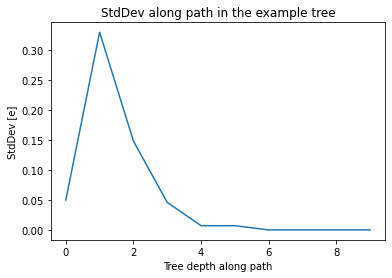

In [37]:
ax = pd.Series(stdDev_in_path).plot.line(label="StdDev [e]")
ax.set_xlabel("Tree depth along path")
ax.set_ylabel("StdDev [e]")
ax.set_title("StdDev along path in the example tree")

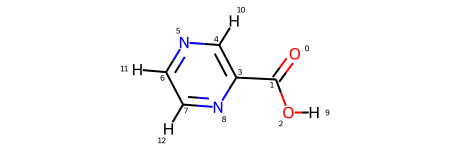

In [38]:
example_mol

In [39]:
for node in path[1:5]:
    af, idx, bond = node.atoms[0]
    print(f"af = {AtomFeatures.lookup_int(af)}, conncted to relative atom_idx = {idx}, with bond order = {bond}")

af = C 3 0 True 0, conncted to relative atom_idx = -1, with bond order = -1
af = O 1 0 True 0, conncted to relative atom_idx = 0, with bond order = 2
af = O 2 0 True 1, conncted to relative atom_idx = 0, with bond order = 1
af = C 3 0 True 0, conncted to relative atom_idx = 0, with bond order = 1


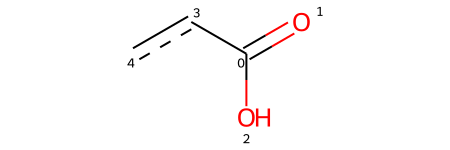

In [44]:
get_rdkit_fragment_from_node_path(path[1:6])

In this case we selected the C atom of a carboxylic acid group and it can be seen, that this functional group is recovered in the path of the tree. The highest attention is on the double bond to the oxygen atom (atom 1 in the fragment), followed by the OH group (atom 2), the C atom (atom 3) and then the aromatic ring. This roughly corresponds to the chemical knowldge of a carboxylic acid group, but it is quantified by the attention values.

## Save the tree

The `Tree` class offers methods for file handling, allowing to save and load the tree from a file. This is useful, if the tree building process takes a long time and the tree needs to be build only once. The tree can then be loaded from the file and used for the assignment of partial charges. The files are human readable csv files, where each line coreesponds to a node in the tree.

In [45]:
for num, child in enumerate(example_tree.root.children):
    child.to_file(f"{out_folder}/tree_{num}.csv")

Saved to ./example_tree_out/tree_0.csv with 1 nodes
Saved to ./example_tree_out/tree_1.csv with 1 nodes
Saved to ./example_tree_out/tree_2.csv with 1 nodes
Saved to ./example_tree_out/tree_3.csv with 1 nodes
Saved to ./example_tree_out/tree_4.csv with 1 nodes
Saved to ./example_tree_out/tree_5.csv with 1 nodes
Saved to ./example_tree_out/tree_6.csv with 5 nodes
Saved to ./example_tree_out/tree_7.csv with 1 nodes
Saved to ./example_tree_out/tree_8.csv with 1 nodes
Saved to ./example_tree_out/tree_9.csv with 1 nodes
Saved to ./example_tree_out/tree_10.csv with 1 nodes
Saved to ./example_tree_out/tree_11.csv with 1 nodes
Saved to ./example_tree_out/tree_12.csv with 1 nodes
Saved to ./example_tree_out/tree_13.csv with 1 nodes
Saved to ./example_tree_out/tree_14.csv with 1 nodes
Saved to ./example_tree_out/tree_15.csv with 1 nodes
Saved to ./example_tree_out/tree_16.csv with 1 nodes
Saved to ./example_tree_out/tree_17.csv with 1 nodes
Saved to ./example_tree_out/tree_18.csv with 1 nodes
Sav

The tree can then beloded, either from a single file, or from a folder with files for all branches of the tree.

In [46]:
example_tree_2 = tree()
example_tree_2.from_folder(out_folder)

In [48]:
len(example_tree_2.root.children)

122

Clean up all the files created by this notebook

In [49]:
rmtree(out_folder)